In [1]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import Preprocessing as pp
import scipy
from sklearn import metrics
import warnings
warnings.filterwarnings(action = 'once')

In [2]:
OPEN_FOLDER = '../Data/Temp_Data/'

In [3]:
input_data = pp.openCSVFile('experiment_1.csv', OPEN_FOLDER)
input_data

,spinning_soll,time,el_power,th_power,input_voltage,spinning_ist
0,0.000000,0.00000,277.475396,121.785258,0,0
1,3996.492326,0.19982,127.346510,115.213041,10,3996
2,3996.994912,1.39874,130.251861,147.214372,10,3994
3,3996.365506,2.59766,128.092478,153.764163,10,3992
4,3996.988395,3.79658,128.680763,132.849924,10,3990
...,...,...,...,...,...,...
11970,0.000000,11977.12674,384.896935,3703.468626,0,0
11971,0.000000,11978.12584,429.568603,3462.908501,0,0
11972,0.000000,11979.12494,257.479754,3651.875786,0,0
11973,0.000000,11980.12404,278.023207,3421.420301,0,0


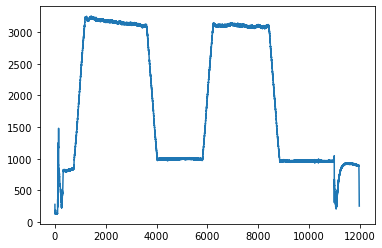

In [4]:
plt.plot(input_data['time'], input_data['el_power'])

### Thermal output 

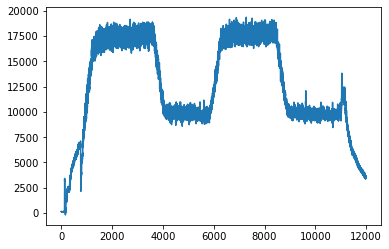

In [5]:
plt.plot(input_data['time'], input_data['th_power'])

In [6]:
def findBounds(dataTime, dataValue):
    fig,axs = plt.subplots(round((len(time_splits))/2), 2, figsize = (20,12))
    axs = axs.ravel()
    axs[0].plot(dataTime, dataValue)
    
    for t in range(len(time_splits) -1):
        cut_point_prior = math.ceil(time_splits[t])
        cut_point_post = math.ceil(time_splits[t+1])
        axs[t+1].plot(dataTime[cut_point_prior:cut_point_post], dataValue[cut_point_prior:cut_point_post])

In [7]:
time_splits = [int(input_data.iloc[x]['time']) for x in range(len(input_data)-1) if input_data.iloc[x]['input_voltage'] != input_data.iloc[x+1]['input_voltage']]
time_splits.append(len(input_data))
time_splits[-2] = 11025
time_splits.insert(1, 850)
time_splits

[0, 850, 3619, 5823, 8439, 11025, 11975]

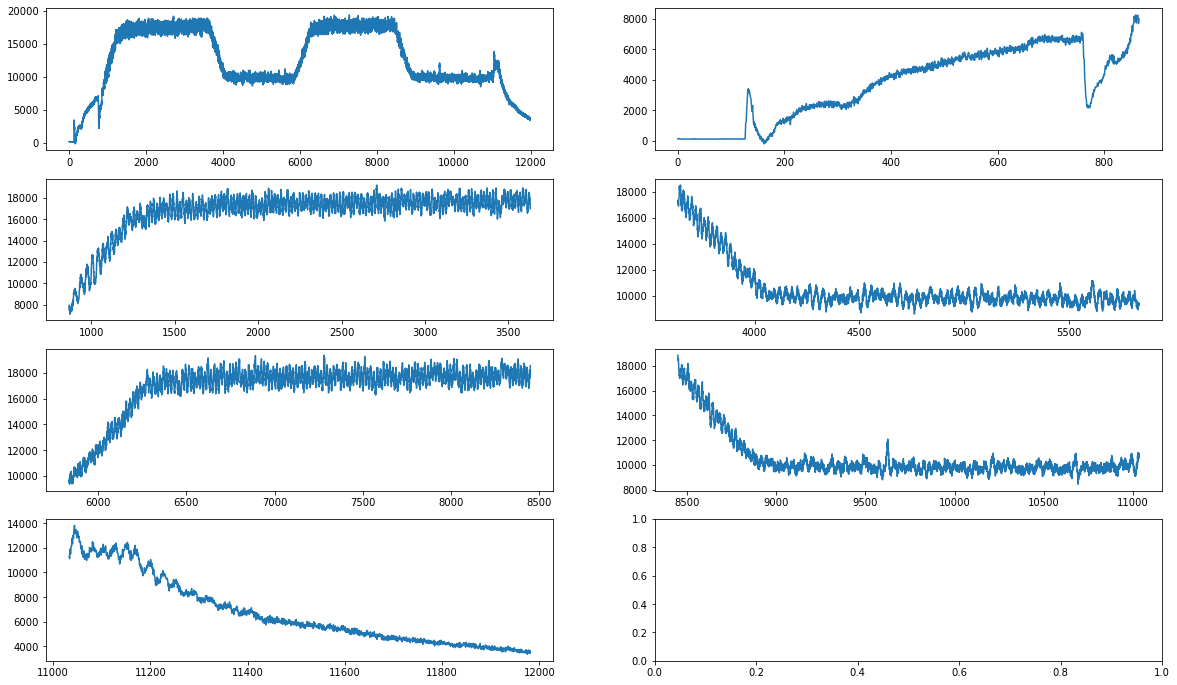

In [8]:
findBounds(input_data['time'], input_data['th_power'])

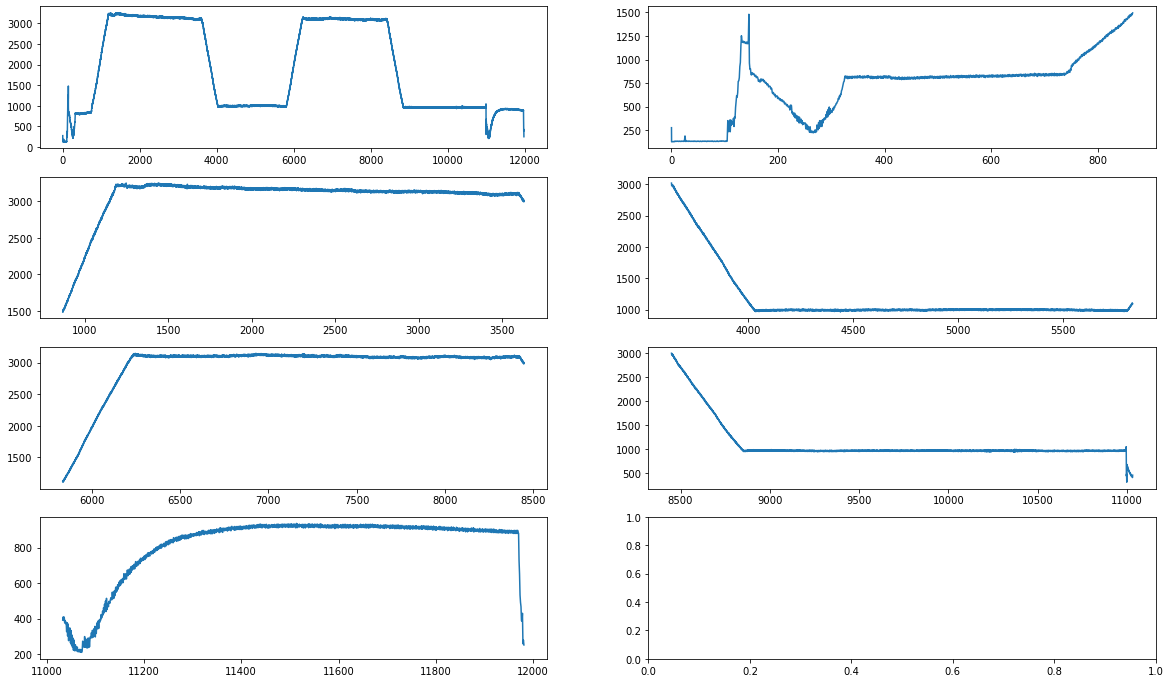

In [9]:
findBounds(input_data['time'], input_data['el_power'])

### Approximate using regression method

Formula to approximate is -k* np.exp((-1/tau)* time) +k \
In the approximations by Dustin k was 5900 and tau 330 or 680

In [10]:
def approx_func(x, k, tau):
    return -k* np.exp((-1/tau)*x) +k

In [11]:
def approx(time, values, prior):
    assert len(time) == len(values), 'time and values should have the same length'
    segment_start_value = values[prior]
    param_bounds = ([-np.inf, 50], [np.inf, np.inf])
    para_fit, pcov = scipy.optimize.curve_fit(approx_func, time-prior, values- segment_start_value, bounds=param_bounds)
    k_best = para_fit[0]
    tau_best = para_fit[1]
    return k_best, tau_best

In [12]:
def allApproximation(dataTime, dataValue):
    fig,axs = plt.subplots(math.ceil(len(time_splits)/2), 2, figsize = (20,12))
    axs = axs.ravel()
    approximations = np.full(shape = len(dataTime), fill_value= np.nan)
    for t in range(len(time_splits) -1):
        cut_point_prior = math.ceil(time_splits[t])
        cut_point_post = math.ceil(time_splits[t+1])
        time_segment = dataTime[cut_point_prior:cut_point_post]
        value_segment = dataValue[cut_point_prior:cut_point_post]
       
        k_best, tau_best = approx(dataTime[cut_point_prior:cut_point_post],
                                  dataValue[cut_point_prior:cut_point_post],
                                  cut_point_prior)
        
        segment_approximation = approx_func(time_segment-cut_point_prior, k_best, tau_best)+dataValue[cut_point_prior]
        axs[t].plot(time_segment, value_segment)
        axs[t].plot(time_segment, segment_approximation)
        approximations[cut_point_prior:cut_point_post] = segment_approximation
    
    axs[-1].plot(dataTime, dataValue)
    axs[-1].plot(dataTime, approximations)
    return approximations

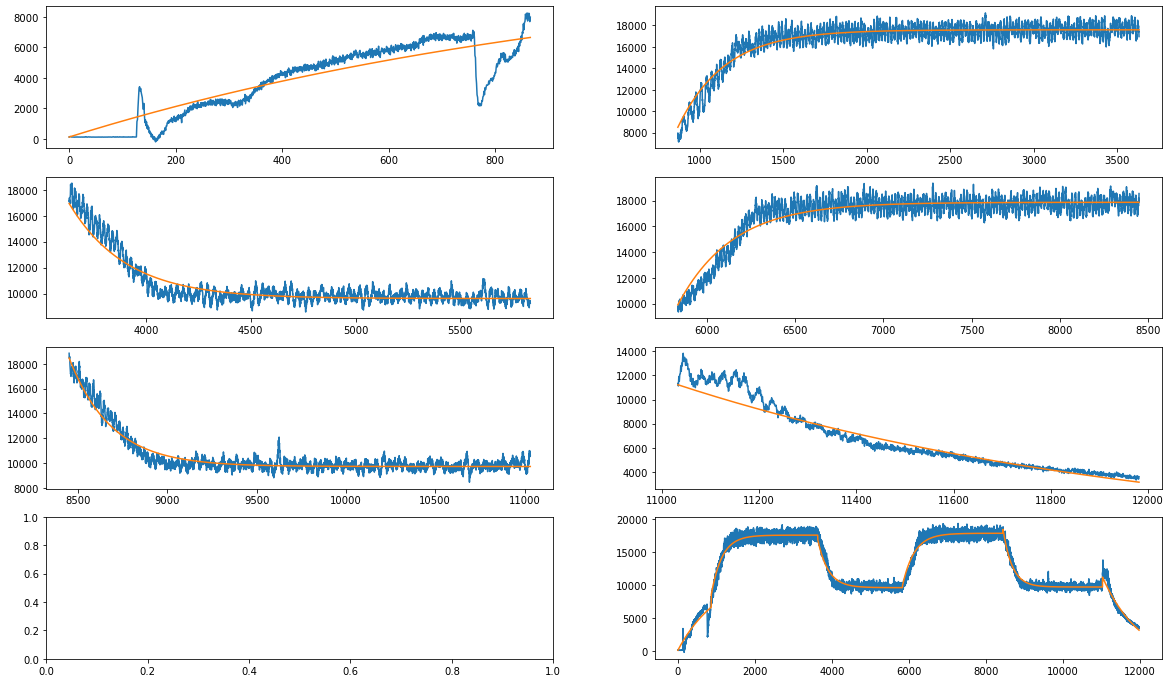

In [13]:
input_data['th_approx'] = allApproximation(input_data['time'], input_data['th_power'])

In [14]:
#colors
kit_green = '#009682'
kit_blue = '#4664AA'
kit_orange = '#DF9B1B'

image_path = "../Images/"
image_subfolder = "Proposal/"
image_folder = image_path + image_subfolder

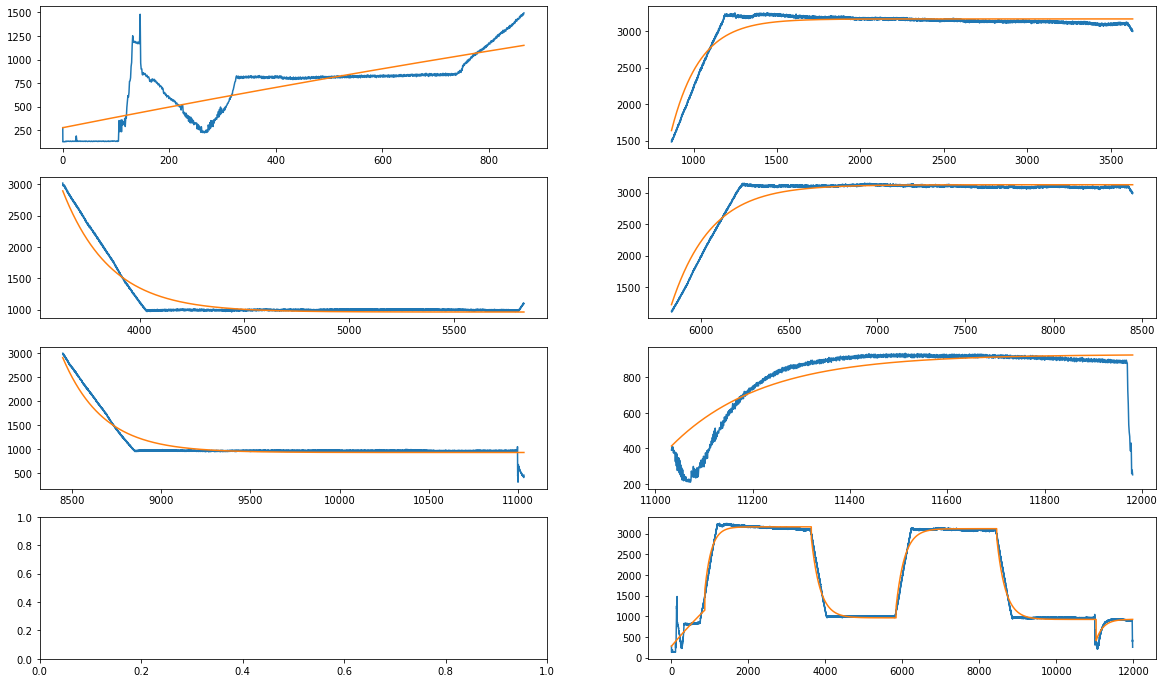

In [15]:
input_data['el_approx'] = allApproximation(input_data['time'], input_data['el_power'])

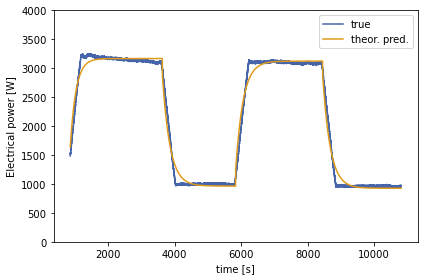

In [24]:
cutpoint = 850
uppercut = 10800

fig, ax1 = plt.subplots()

color = kit_blue
ax1.plot(input_data['time'][cutpoint:uppercut], input_data['el_power'][cutpoint:uppercut], label = 'true', color = color)
ax1.set_ylabel('Electrical power [W]')
ax1.set_ylim([0,4000])
ax1.set_xlabel('time [s]')

color = kit_orange
ax1.plot(input_data['time'][cutpoint:uppercut], input_data['el_approx'][cutpoint:uppercut], label = 'theor. pred.', color = color)
fig.tight_layout()
plt.legend()
plt.savefig(image_folder + 'ex4_theo_compar_elec.svg')
plt.savefig(image_folder + 'ex4_theo_compar_elec.png')
plt.show()

In [17]:
def measureDifference(data, value_header, approx_header):
    R_SQUARED = True
    RSME = True
    
    data = data[data[approx_header].notnull()]
    values = data[value_header]
    approx = data[approx_header]
    
    if RSME:
        rms = metrics.mean_squared_error(values, approx, squared=False)
        print('The RMSE is %5.3f' %rms)
    if R_SQUARED:
        r2 = metrics.r2_score(values, approx)
        print('The R2-score is %5.3f' %r2)

In [18]:
measureDifference(input_data, 'el_power', 'el_approx')

The RMSE is 112.829
The R2-score is 0.989
